In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt


In [2]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/synth_topk_torch/'
exps = glob.glob(base_dir + '/*')

In [ ]:
!ls /cluster/tufts/hugheslab/kheuto01/synth_topk_torch/

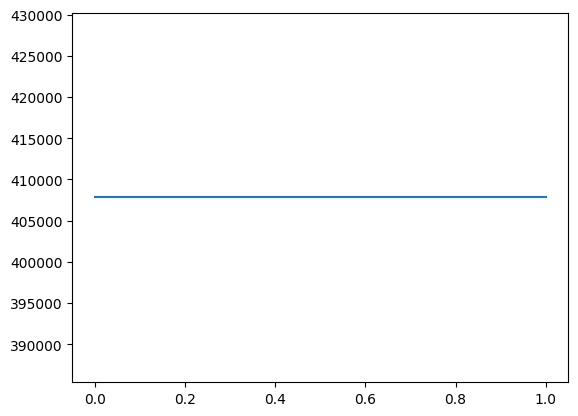

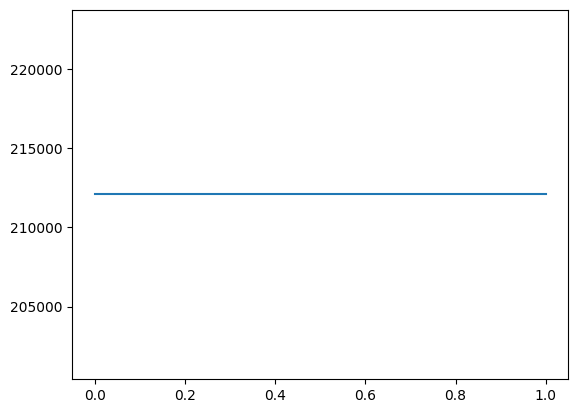

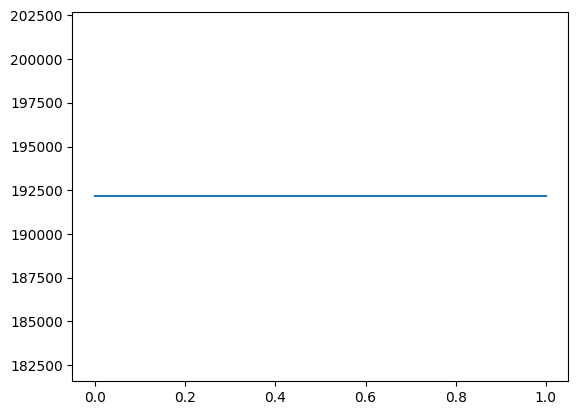

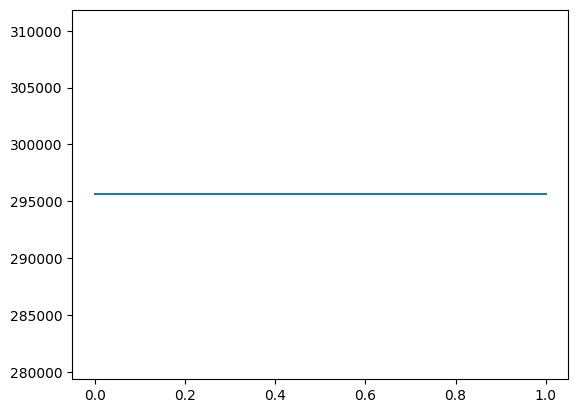

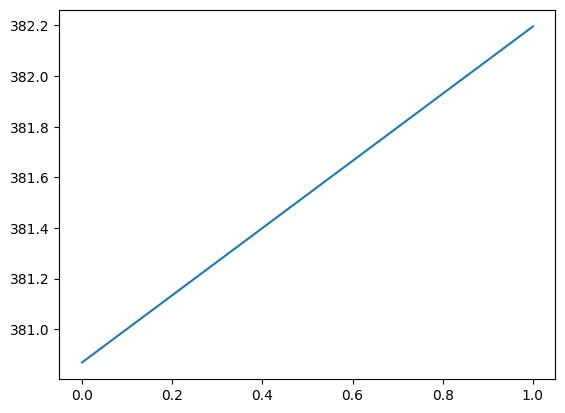

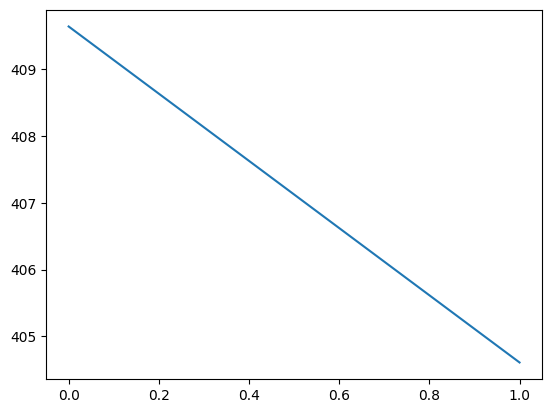

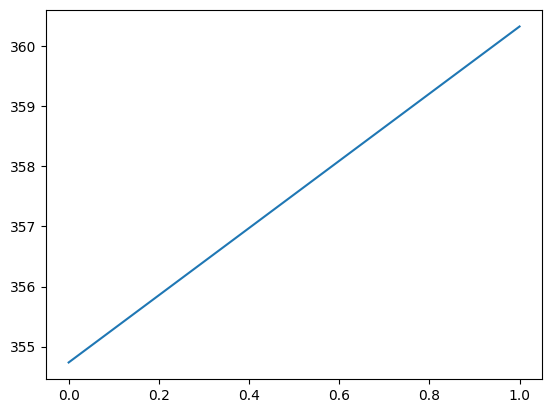

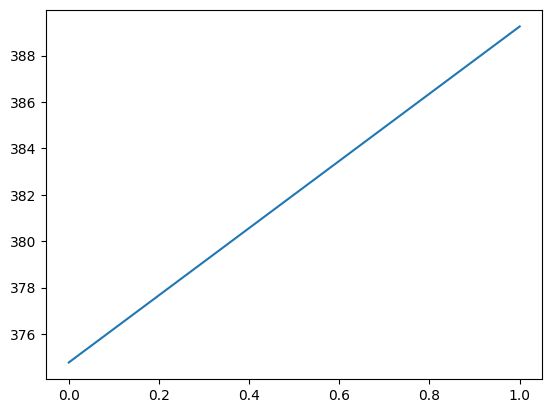

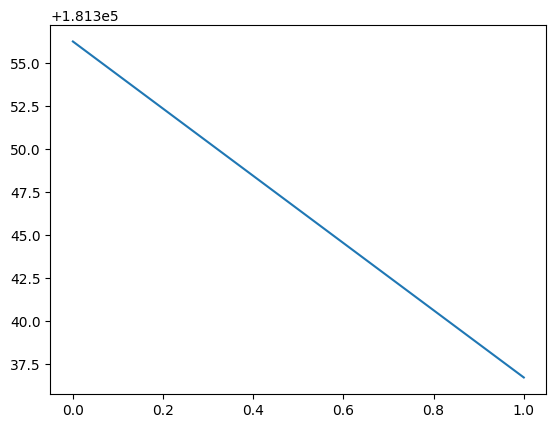

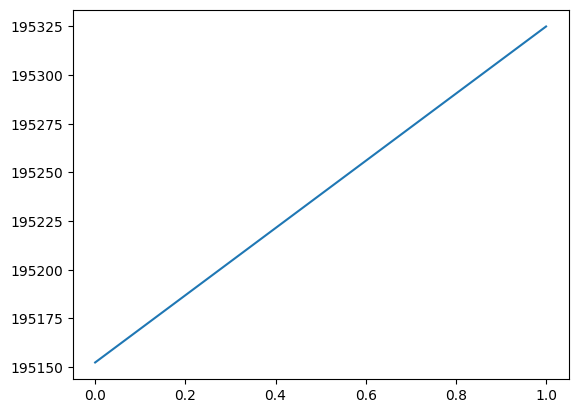

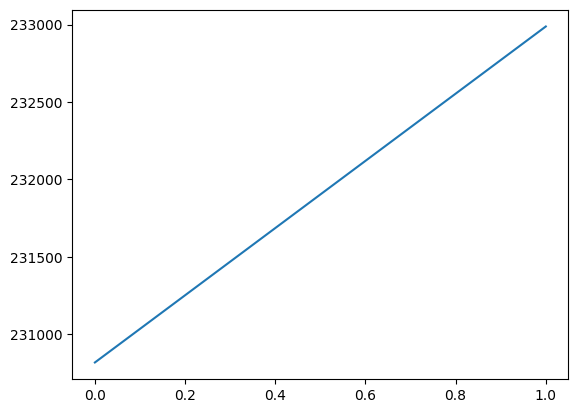

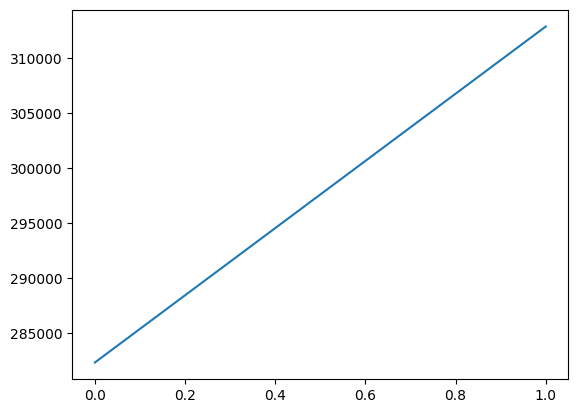

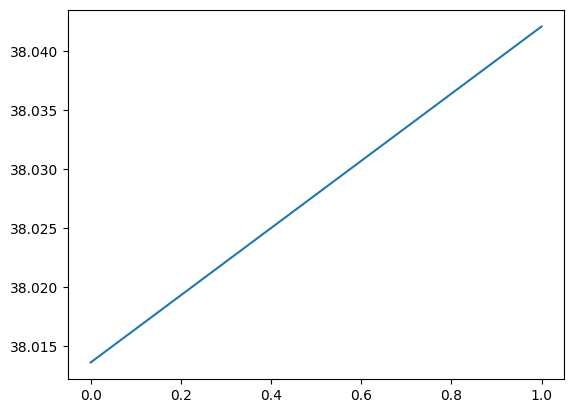

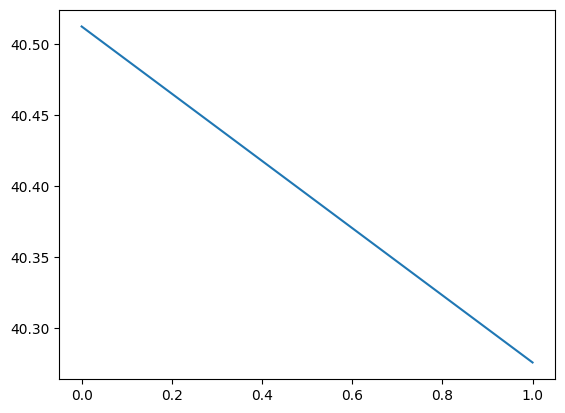

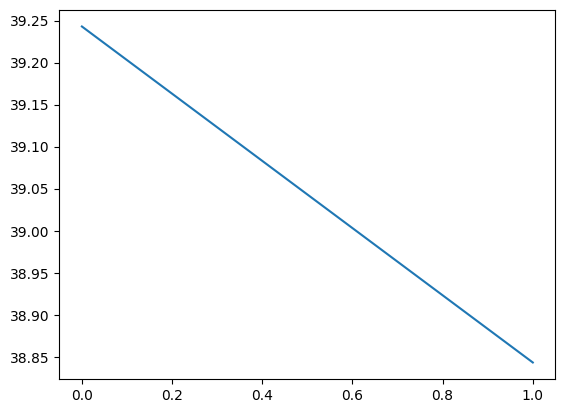

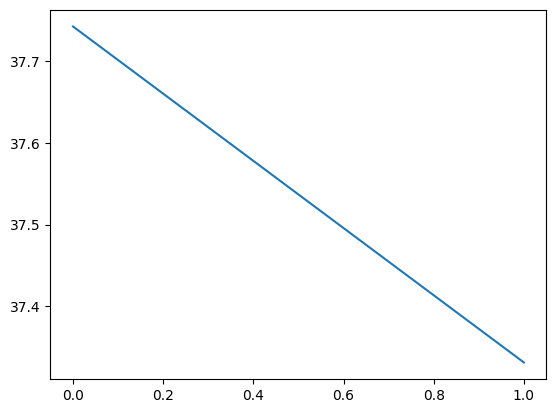

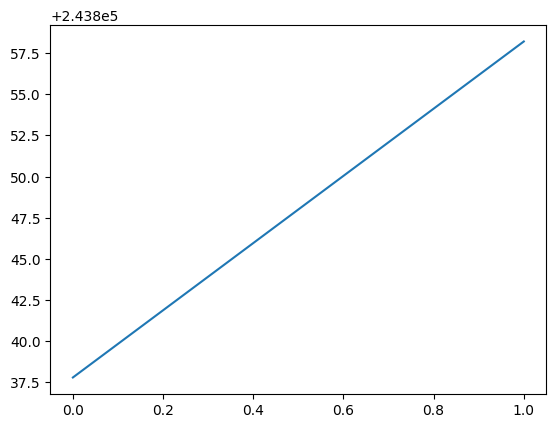

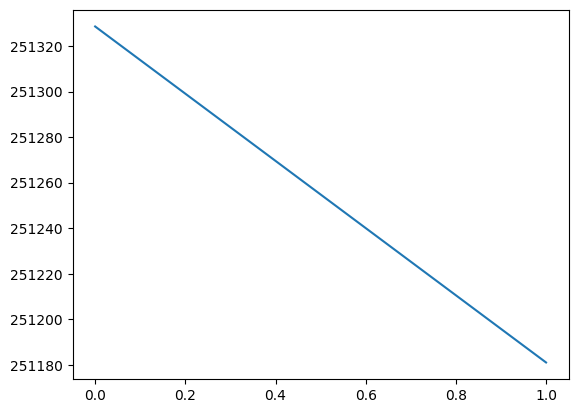

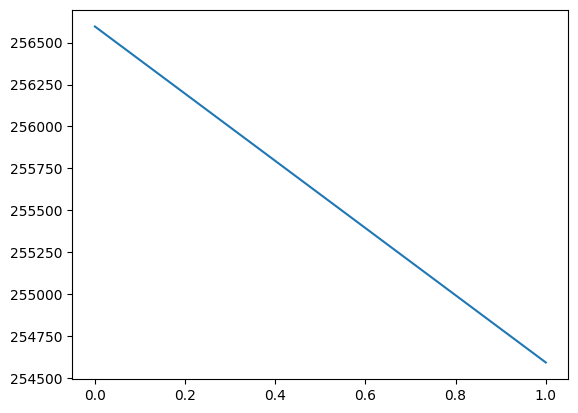

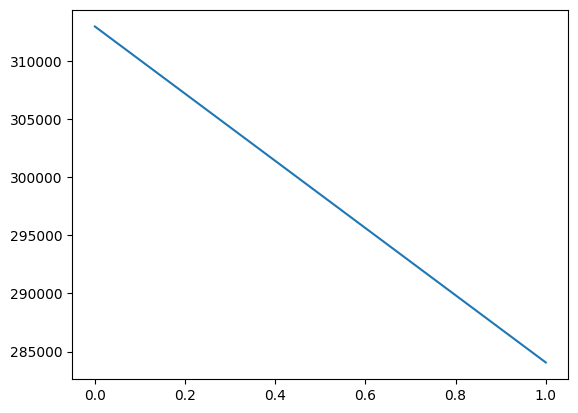

In [12]:
for exp in exps:
    plt.figure()
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')
    losses = [loss.detach().numpy() for loss in losses]
    bprs = [bpr.detach().numpy() for bpr in bprs]
    nlls = [nll.detach().numpy() for nll in nlls]
    
    plt.plot(losses)

In [8]:
losses

[array(312944.16, dtype=float32), array(284056.56, dtype=float32)]

In [10]:
exp

'/cluster/tufts/hugheslab/kheuto01/synth_topk_torch/bw500_nw1_ss0.1_th0.55'

In [11]:
!ls /cluster/tufts/hugheslab/kheuto01/synth_topk_torch/bw500_nw1_ss0.1_th0.55

bprs.pth  losses.pth  model.pth  nlls.pth  optimizer.pth
